In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"   
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Dropout, BatchNormalization, Input, Layer, Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy
from pandas_datareader import data
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC#Download data from the web via this package


from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
GSPC = pd.read_csv('GSPC_index_close_test123.csv')
del GSPC['Date']
GSPC=GSPC.T
GSPC_noisy = pd.DataFrame(np.repeat(GSPC.values,100,axis=0))
GSPC_noisy=GSPC_noisy.iloc[:, 52:]


In [3]:
GSPC_noisy

,52,53,54,55,56,57,58,59,60,61,...,492,493,494,495,496,497,498,499,500,501
0,2373.469971,2344.02002,2348.449951,2345.959961,2343.97998,2341.590088,2358.570068,2361.129883,2368.060059,2362.719971,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
1,2373.469971,2344.02002,2348.449951,2345.959961,2343.97998,2341.590088,2358.570068,2361.129883,2368.060059,2362.719971,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
2,2373.469971,2344.02002,2348.449951,2345.959961,2343.97998,2341.590088,2358.570068,2361.129883,2368.060059,2362.719971,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
3,2373.469971,2344.02002,2348.449951,2345.959961,2343.97998,2341.590088,2358.570068,2361.129883,2368.060059,2362.719971,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
4,2373.469971,2344.02002,2348.449951,2345.959961,2343.97998,2341.590088,2358.570068,2361.129883,2368.060059,2362.719971,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2373.469971,2344.02002,2348.449951,2345.959961,2343.97998,2341.590088,2358.570068,2361.129883,2368.060059,2362.719971,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
96,2373.469971,2344.02002,2348.449951,2345.959961,2343.97998,2341.590088,2358.570068,2361.129883,2368.060059,2362.719971,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
97,2373.469971,2344.02002,2348.449951,2345.959961,2343.97998,2341.590088,2358.570068,2361.129883,2368.060059,2362.719971,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
98,2373.469971,2344.02002,2348.449951,2345.959961,2343.97998,2341.590088,2358.570068,2361.129883,2368.060059,2362.719971,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098


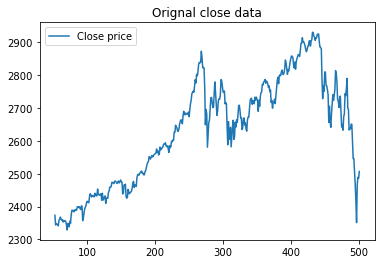

In [4]:
plt.plot(GSPC_noisy.iloc[0],label='Close price')
plt.title('Orignal close data')
plt.legend()

In [5]:
close=np.array(GSPC)[0]
GSPC_pure=pd.DataFrame()
for i in range(2,52):#SMA
    #print(i)
    n=np.ones(i)
    weights_sma=n/i
    empty=np.ones(i-1)
    sma=np.convolve(weights_sma, close, mode='valid')
    sma_full=np.hstack((empty,sma))
    GSPC_pure=pd.concat([GSPC_pure, pd.DataFrame(sma_full).T],ignore_index=True)
    weights_ema=np.exp(np.linspace(0,1,i))
    weights_ema =weights_ema/np.sum(weights_ema)
    ema=np.convolve(weights_ema, close, mode='valid')
    ema_full=np.hstack((empty,sma))
    GSPC_pure=pd.concat([GSPC_pure, pd.DataFrame(ema_full).T],ignore_index=True)
GSPC_pure=GSPC_pure.iloc[:, 52:]

In [6]:
GSPC_pure

,52,53,54,55,56,57,58,59,60,61,...,492,493,494,495,496,497,498,499,500,501
0,2375.859985,2358.744995,2346.234985,2347.204956,2344.969971,2342.785034,2350.080078,2359.849976,2364.594971,2365.390015,...,2572.944946,2546.049927,2526.559937,2487.189941,2442.020020,2383.860107,2409.400024,2478.265015,2487.285034,2496.295044
1,2375.859985,2358.744995,2346.234985,2347.204956,2344.969971,2342.785034,2350.080078,2359.849976,2364.594971,2365.390015,...,2572.944946,2546.049927,2526.559937,2487.189941,2442.020020,2383.860107,2409.400024,2478.265015,2487.285034,2496.295044
2,2377.699951,2365.246663,2355.313314,2346.143311,2346.129964,2343.843343,2348.046712,2353.763346,2362.586670,2363.969971,...,2598.809977,2564.016602,2533.019938,2506.846598,2463.666667,2411.713379,2411.806722,2435.876709,2480.756673,2493.806722
3,2377.699951,2365.246663,2355.313314,2346.143311,2346.129964,2343.843343,2348.046712,2353.763346,2362.586670,2363.969971,...,2598.809977,2564.016602,2533.019938,2506.846598,2463.666667,2411.713379,2411.806722,2435.876709,2480.756673,2493.806722
4,2379.589966,2369.279968,2361.047485,2352.974976,2345.602478,2344.994995,2347.525024,2351.317505,2357.337524,2362.619995,...,2611.875000,2585.647461,2549.752441,2516.619934,2484.289978,2435.525024,2425.710022,2431.062561,2448.342529,2487.280029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2325.683464,2327.216528,2328.839998,2330.281629,2331.782446,2333.148776,2334.999392,2336.820616,2338.950619,2340.816127,...,2719.067343,2712.163873,2704.543871,2698.048768,2691.686523,2683.196120,2677.418771,2670.865917,2664.264489,2658.918980
96,2324.709395,2326.050195,2327.641196,2329.182397,2330.555596,2331.978599,2333.657202,2335.522002,2337.445405,2339.426006,...,2722.397397,2715.609194,2708.059795,2699.801392,2692.420195,2684.874795,2678.886196,2673.646997,2667.163398,2661.116201
97,2324.709395,2326.050195,2327.641196,2329.182397,2330.555596,2331.978599,2333.657202,2335.522002,2337.445405,2339.426006,...,2722.397397,2715.609194,2708.059795,2699.801392,2692.420195,2684.874795,2678.886196,2673.646997,2667.163398,2661.116201
98,2323.617053,2325.088034,2326.489406,2328.000388,2329.472546,2330.771958,2332.500000,2334.195882,2336.160003,2337.940985,...,2725.911372,2718.941760,2711.518033,2703.341366,2694.248818,2685.727644,2680.616465,2675.159606,2669.962546,2664.020000


## MinMaxScaler

In [7]:
mm = MinMaxScaler()
noise_mm = mm.fit_transform(GSPC_noisy.T).T
prue_mm=mm.transform(GSPC_pure.T).T


In [8]:
train_cleaned_mm=np.reshape(prue_mm, (100, 450, 1))
train_mm=np.reshape(noise_mm, (100, 450, 1))

In [9]:
# convert list to numpy array
X_train_mm = np.asarray(train_mm)
Y_train_mm = np.asarray(train_cleaned_mm)
X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(X_train_mm, Y_train_mm, test_size=0.2,random_state=0)

## LSTM

In [13]:
def set_model_LSTM():
    model = Sequential()
    model.add(LSTM(128, input_shape=(450, 1),activation='tanh', return_sequences = True))
    model.add(LSTM(64, activation='tanh',return_sequences = True))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2, padding='same'))
    model.add(Dropout(0.2))
    model.add(LSTM(64, activation='tanh',return_sequences = True))
    model.add(LSTM(128, activation='tanh',return_sequences = True))
    model.add(BatchNormalization())
    model.add(UpSampling1D(2))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mse'])
    return model
modelen_LSTM = set_model_LSTM()
modelen_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 450, 128)          66560     
                                                                 
 lstm_5 (LSTM)               (None, 450, 64)           49408     
                                                                 
 batch_normalization_2 (Batc  (None, 450, 64)          256       
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 225, 64)          0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 225, 64)           0         
                                                                 
 lstm_6 (LSTM)               (None, 225, 64)          

In [14]:
callback = EarlyStopping(monitor='loss', patience=30)
history_LSTM = modelen_LSTM.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=200, batch_size=8, verbose=1, callbacks=[callback])

Epoch 1/200
10/10 [==============================] - 8s 351ms/step - loss: 0.0436 - mse: 0.0436 - val_loss: 0.0668 - val_mse: 0.0668
Epoch 2/200
10/10 [==============================] - 2s 245ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0633 - val_mse: 0.0633
Epoch 3/200
10/10 [==============================] - 2s 247ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0614 - val_mse: 0.0614
Epoch 4/200
10/10 [==============================] - 2s 242ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0604 - val_mse: 0.0604
Epoch 5/200
10/10 [==============================] - 2s 242ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0592 - val_mse: 0.0592
Epoch 6/200
10/10 [==============================] - 2s 239ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0577 - val_mse: 0.0577
Epoch 7/200
10/10 [==============================] - 2s 239ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0557 - val_mse: 0.0557
Epoch 8/200
10/10 [==============================] - 2s 239ms/step - 

10/10 [==============================] - 2s 237ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 63/200
10/10 [==============================] - 2s 238ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 64/200
10/10 [==============================] - 2s 236ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 65/200
10/10 [==============================] - 2s 237ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 66/200
10/10 [==============================] - 2s 236ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 67/200
10/10 [==============================] - 2s 236ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 68/200
10/10 [==============================] - 2s 235ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 69/200
10/10 [==============================] - 2s 234ms/step - loss:

10/10 [==============================] - 2s 234ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 124/200
10/10 [==============================] - 2s 238ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 125/200
10/10 [==============================] - 2s 234ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 126/200
10/10 [==============================] - 2s 235ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 127/200
10/10 [==============================] - 2s 232ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 128/200
10/10 [==============================] - 2s 233ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 129/200
10/10 [==============================] - 2s 232ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 130/200
10/10 [==============================] - 2s 231ms/step 

In [18]:
modelen_LSTM.save_weights('model_weights_LSTM.h5', overwrite=True) 

In [11]:
modelen_LSTM.load_weights('model_weights_LSTM.h5') 

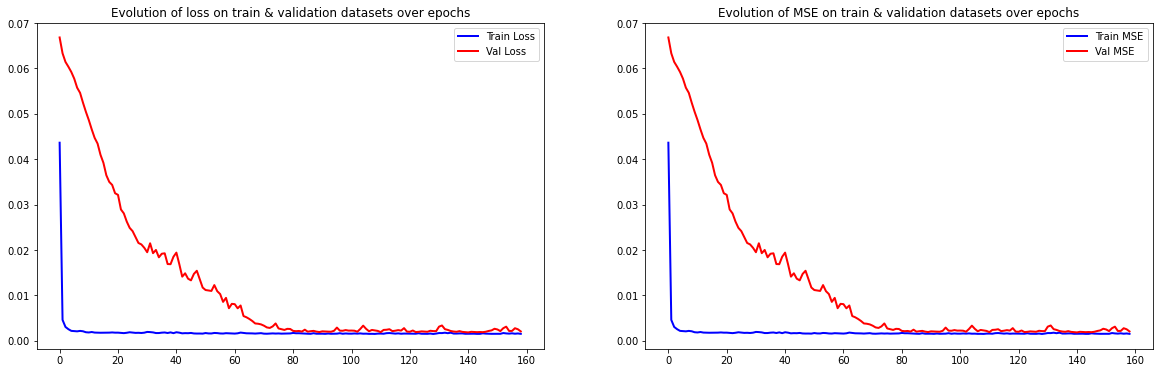

In [15]:
# Check how loss & mae went down
epoch_loss = history_LSTM.history['loss']
epoch_val_loss = history_LSTM.history['val_loss']
epoch_mse = history_LSTM.history['mse']
epoch_val_mse = history_LSTM.history['val_mse']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mse)), epoch_mse, 'b-', linewidth=2, label='Train MSE')
plt.plot(range(0,len(epoch_val_mse)), epoch_val_mse, 'r-', linewidth=2,label='Val MSE')
plt.title('Evolution of MSE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [16]:
GSPC_test = pd.read_csv('GSPC_index_close_test123.csv')
Date=pd.to_datetime(GSPC_test['Date'])
del GSPC_test['Date']
#GSPC_test=GSPC_test.T
GSPC_test=GSPC_test[0:450]

1/1 [==============================] - 0s 51ms/step


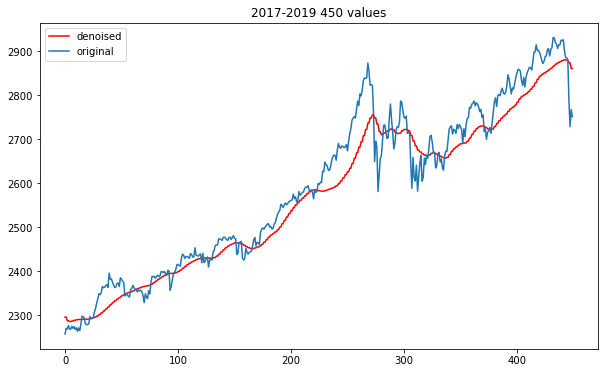

In [97]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_lstm = modelen_LSTM.predict(noise_mm_T.T, batch_size=32)
Y_test_mm_lstm=Y_test_mm_lstm.reshape((450,1))
pure_mm_lstm = mm_t.inverse_transform(Y_test_mm_lstm)
pure_mm_lstm=pd.DataFrame(pure_mm_lstm)
plt.figure(figsize=(10,6))
plt.plot(pure_mm_lstm,'r')
plt.plot(GSPC_test)
plt.title('2017-2019 450 values')
plt.legend(['denoised', 'original'], loc='upper left')

In [41]:
def set_model_encoding_mm():
    model = Sequential()
    #encoding
    model.add(Conv1D(128, kernel_size=3, activation='tanh', padding='same',input_shape=(450, 1)))
    model.add(Conv1D(64, kernel_size=3,activation='sigmoid',padding='same'))
    model.add(BatchNormalization())
    #Use the normalization preprocessing of the data as mentioned before, so that the input x does not vary too much
    model.add(MaxPooling1D(2, padding='same'))
    model.add(Dropout(0.5))
    #decoding
    model.add(Conv1D(64, kernel_size=3, activation='sigmoid', padding='same'))
    model.add(Conv1D(128, kernel_size=3,activation='tanh',padding='same'))
    model.add(BatchNormalization())
    model.add(UpSampling1D(2))
    
    model.add(Conv1D(1,kernel_size=3,activation='sigmoid', padding='same'))
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mse'])
    
    return model
modelen_mm = set_model_encoding_mm()
modelen_mm.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_35 (Conv1D)          (None, 450, 128)          512       
                                                                 
 conv1d_36 (Conv1D)          (None, 450, 64)           24640     
                                                                 
 batch_normalization_18 (Bat  (None, 450, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 225, 64)          0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 225, 64)           0         
                                                                 
 conv1d_37 (Conv1D)          (None, 225, 64)          

In [42]:
callback = EarlyStopping(monitor='loss', patience=30)
history_mm = modelen_mm.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=500, batch_size=4, verbose=1, callbacks=[callback])

Epoch 1/500
20/20 [==============================] - 2s 17ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0967 - val_mse: 0.0967
Epoch 2/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0946 - val_mse: 0.0946
Epoch 3/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0842 - val_mse: 0.0842
Epoch 4/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0900 - val_mse: 0.0900
Epoch 5/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0917 - val_mse: 0.0917
Epoch 6/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0936 - val_mse: 0.0936
Epoch 7/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0909 - val_mse: 0.0909
Epoch 8/500
20/20 [==============================] - 0s 10ms/step - loss: 0.

Epoch 63/500
20/20 [==============================] - 0s 9ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 64/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 65/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 66/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 67/500
20/20 [==============================] - 0s 9ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0508 - val_mse: 0.0508
Epoch 68/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 69/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 70/500
20/20 [==============================] - 0s 10ms/step - lo

20/20 [==============================] - 0s 10ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 125/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 126/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 127/500
20/20 [==============================] - 0s 9ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 128/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 129/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 130/500
20/20 [==============================] - 0s 9ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 131/500
20/20 [==============================] - 0s 10ms/step - loss: 0.

20/20 [==============================] - 0s 9ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 186/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 187/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 188/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 189/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 190/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 191/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 192/500
20/20 [==============================] - 0s 10ms/step - loss: 0

20/20 [==============================] - 0s 10ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 247/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 248/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 249/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 250/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 251/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 252/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 253/500
20/20 [==============================] - 0s 11ms/step - loss: 

20/20 [==============================] - 0s 10ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 308/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 309/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0039 - val_mse: 0.0039


In [45]:
modelen_mm.save_weights('model_weights_mm.h5', overwrite=True)  

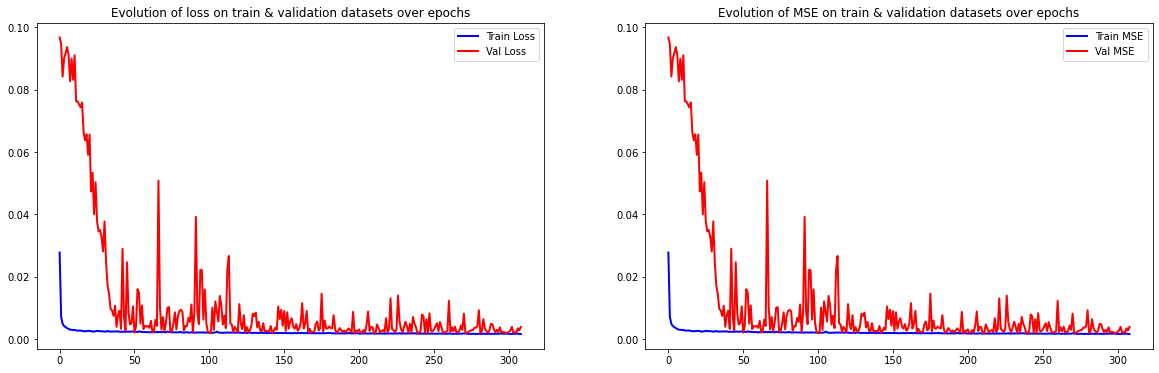

In [43]:
# Check how loss & mae went down
epoch_loss = history_mm.history['loss']
epoch_val_loss = history_mm.history['val_loss']
epoch_mse = history_mm.history['mse']
epoch_val_mse = history_mm.history['val_mse']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mse)), epoch_mse, 'b-', linewidth=2, label='Train MSE')
plt.plot(range(0,len(epoch_val_mse)), epoch_val_mse, 'r-', linewidth=2,label='Val MSE')
plt.title('Evolution of MSE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [18]:
modelen_mm.load_weights('model_weights_mm.h5') 

In [21]:
GSPC_test = pd.read_csv('GSPC_index_close_test123.csv')
Date=pd.to_datetime(GSPC_test['Date'])
del GSPC_test['Date']
#GSPC_test=GSPC_test.T
GSPC_test=GSPC_test[0:450]

1/1 [==============================] - 0s 14ms/step


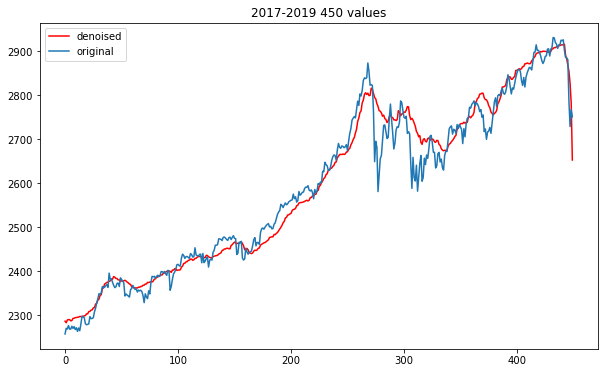

In [96]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_cnn = modelen_mm.predict(noise_mm_T.T, batch_size=8)
Y_test_mm_cnn=Y_test_mm_cnn.reshape((450,1))
pure_mm_cnn = mm_t.inverse_transform(Y_test_mm_cnn)
pure_mm_cnn=pd.DataFrame(pure_mm_cnn)
plt.figure(figsize=(10,6))
plt.plot(pure_mm_cnn,'r')
plt.plot(GSPC_test)
plt.title('2017-2019 450 values')
plt.legend(['denoised', 'original'], loc='upper left')

In [46]:
def log_return(dataset):
    daily_log_rets = np.diff(np.log(dataset).T)
    daily_log_rets=daily_log_rets.reshape(len(dataset)-1)
    daily_rets_series = pd.DataFrame(daily_log_rets)#calculate the log return
    return daily_rets_series

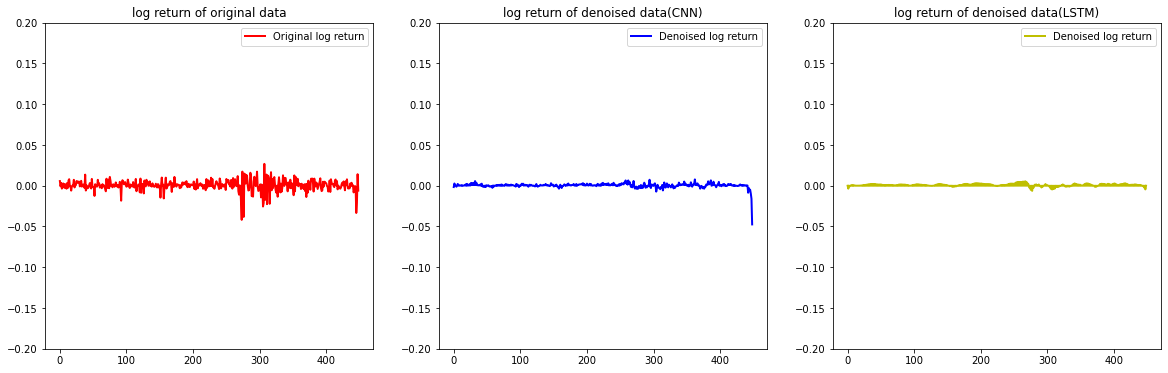

In [47]:
o=log_return(GSPC_test)
d_cnn=log_return(pure_mm_cnn)
d_lstm=log_return(pure_mm_lstm)

plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.plot(o, 'r-', linewidth=2, label='Original log return')
plt.ylim(-0.2,0.2)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,3,2)
plt.plot(d_cnn, 'b-', linewidth=2, label='Denoised log return')
plt.ylim(-0.2,0.2)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')

plt.subplot(1,3,3)
plt.plot(d_lstm, 'y-', linewidth=2, label='Denoised log return')
plt.ylim(-0.2,0.2)
plt.title('log return of denoised data(LSTM)')
plt.legend(loc='best')

plt.show()

In [79]:
import warnings
warnings.filterwarnings("ignore")

In [86]:
def svmf1(dataset,long_predict=10):
    daily_log_rets = np.diff(np.log(dataset).T)
    daily_log_rets=daily_log_rets.reshape(len(dataset)-1)
    daily_rets_series = pd.DataFrame(daily_log_rets)#calculate the log return
    f1=np.empty(0)
    for n in np.arange(0.0, 0.04, 0.0005):#get multiple threshold
        threshold = n
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(daily_rets_series)):
            if daily_rets_series.iloc[i,0]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(daily_rets_series.iloc[i,0])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(len(daily_rets_series)-long_predict):
            X=pd.concat([X, pd.DataFrame(daily_log_rets[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=0)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        f1=np.append(f1,cross_val_score(svc_rbf , X_train, Y_train, scoring='f1_micro',cv=5).mean())
    return f1

In [98]:
orignal_svm=svmf1(GSPC_test)
denoised_svm=svmf1(pure_mm_cnn)

In [102]:
denoised_svm

array([0.74064386, 0.62104628, 0.61806841, 0.73492958, 0.76635815,
       0.82909457, 0.8917505 , 0.92024145, 0.95158954, 0.95726358,
       0.96869215, 0.9743662 , 0.98293763, 0.98575453, 0.99146881,
       0.99432596, 0.99432596, 0.99432596, 0.99432596, 0.99432596,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [103]:
orignal_svm

array([0.53851107, 0.49577465, 0.43875252, 0.38720322, 0.46716298,
       0.54128773, 0.56696177, 0.58402414, 0.62965795, 0.64672032,
       0.66953722, 0.69802817, 0.72933602, 0.75501006, 0.77492958,
       0.79774648, 0.817666  , 0.85187123, 0.87464789, 0.88321932,
       0.89460765, 0.89460765, 0.90599598, 0.90885312, 0.92309859,
       0.92595573, 0.93162978, 0.94020121, 0.94873239, 0.95444668,
       0.96012072, 0.96012072, 0.96583501, 0.96583501, 0.96869215,
       0.97722334, 0.97722334, 0.98008048, 0.98008048, 0.98008048,
       0.98008048, 0.98008048, 0.98293763, 0.98861167, 0.98861167,
       0.99146881, 0.99146881, 0.99146881, 0.99146881, 0.99146881,
       0.99146881, 0.99432596, 0.99432596, 0.99432596, 0.99432596,
       0.99432596, 0.99432596, 0.99432596, 0.99432596, 0.99432596,
       0.99432596, 0.99432596, 0.99432596, 0.99432596, 0.99432596,
       0.99432596, 0.99432596, 0.99432596, 0.99432596, 0.99432596,
       0.99432596, 0.99432596, 0.99432596, 0.99432596, 0.99432

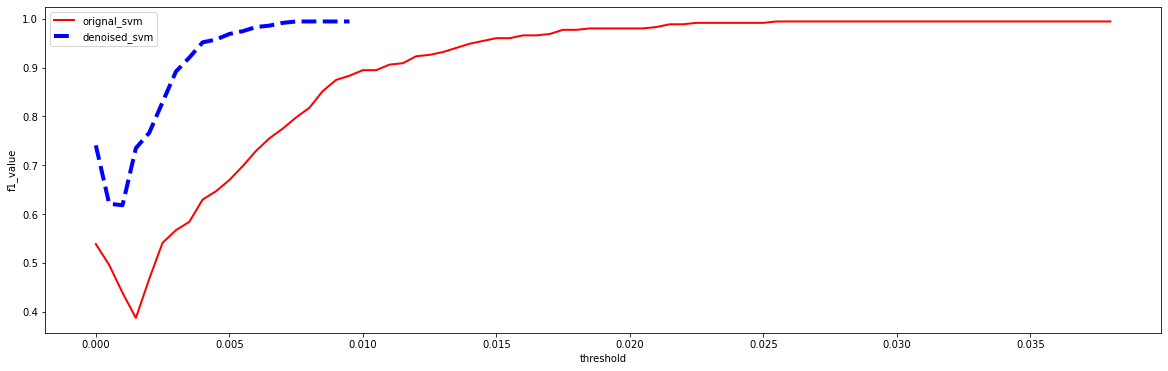

In [99]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(0.0, 0.04, 0.0005),orignal_svm,label='orignal_svm', color='red', linewidth=2.0)
plt.plot(np.arange(0.0, 0.04, 0.0005),denoised_svm,label='denoised_svm', color='blue', linewidth=4.0, linestyle='--')
plt.xticks(np.arange(0.0, 0.04, 0.005))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

## LSTM

In [104]:
orignal_svm=svmf1(GSPC_test)
denoised_svm=svmf1(pure_mm_lstm)

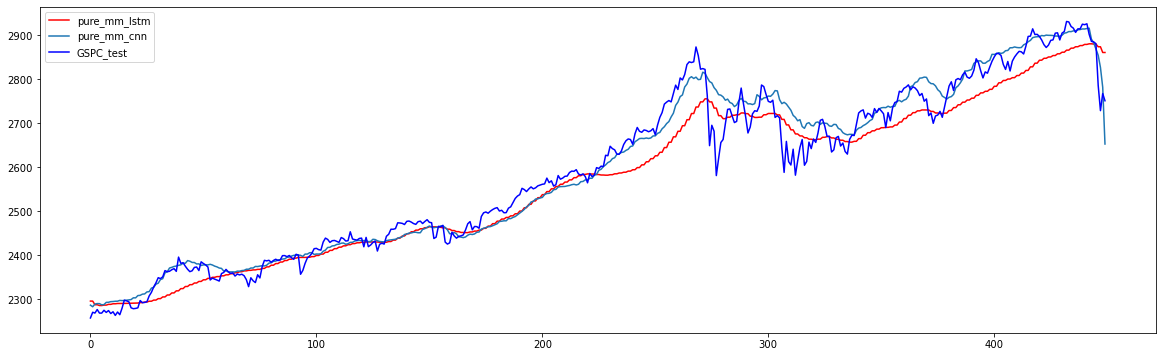

In [90]:
plt.figure(figsize=(20,6))
plt.plot(pure_mm_lstm,'r-',label='pure_mm_lstm')
plt.plot(pure_mm_cnn,label='pure_mm_cnn')
plt.plot(GSPC_test,'b-',label='GSPC_test')
plt.legend()

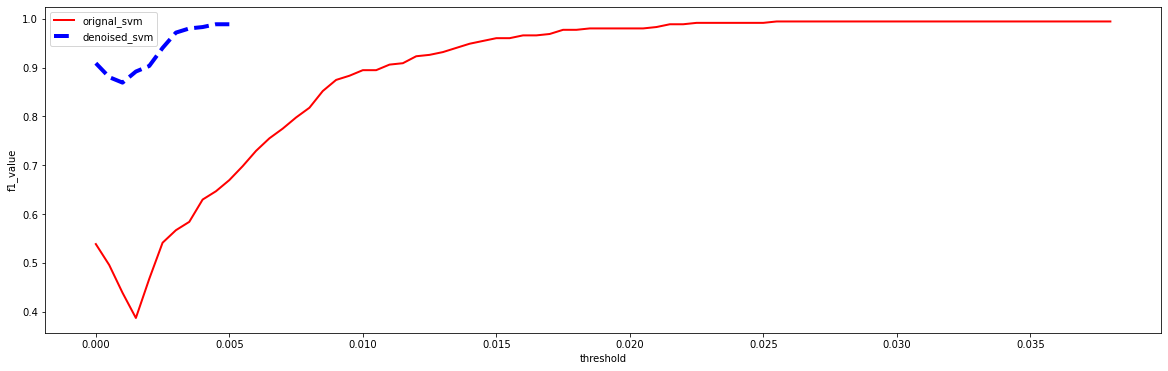

In [105]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(0.0, 0.04, 0.0005),orignal_svm,label='orignal_svm', color='red', linewidth=2.0)
plt.plot(np.arange(0.0, 0.04, 0.0005),denoised_svm,label='denoised_svm', color='blue', linewidth=4.0, linestyle='--')
plt.xticks(np.arange(0.0, 0.04, 0.005))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

In [106]:
pure_mm_lstm.to_csv('pure_mm_lstm.csv')
pure_mm_cnn.to_csv('pure_mm_cnn.csv')